In [4]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':'1-Hh3pdJlxhHWy42ZqXFDdjjBxe4vhoRg'})
downloaded.GetContentFile('train.csv') 

# Base Model


## Importing relevant libraries


In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

## Exploring data


In [2]:
data = pd.read_csv('./nlp-getting-started/train.csv')
# Only alter the training variable (#never alter the data variable itself)
# training = data
# # split the data into train and test set
# train, test = train_test_split(train, test_size=0.1, random_state=42, shuffle=True)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Analysis
- there are 7613 data points
- **99.198739%** of the data has **keywords**
- **66.73%** of the data has **location** points
- the top key word used to extract tweets is **fatalities**
- data is ordered in terms of keyword used to extact the tweet from twitter 
- therefore shuffle the data to mix it.
- some of the data contains the # symbol which causes an error when the data is exported onto a numpy array
- elements in the **text** column which does not have " " marks should not include **,** 
- data in the **location** column may also include **,** marks which will be read as a column delimeter by **np**

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
- the location column can be discarded because only 66.73% have a location value associated with them. Droping 33% of the data is impractical
- it is however worth exploring whether location of tweet has an impact on the real or fake status of a tweet

- in some locations such as a city centre there cannot be a veld fire - so that is a consideration to be made


### Data cleaning

In [3]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()
# data_after_null_removal = data_after_null_removal.dropna(subset=['location'])

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires california even northern part state troubling,1
7610,10871,NaN,NaN,volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...,1


In [4]:
### train - test split
training, testing = train_test_split(data_without_tockenization, test_size=0.1, random_state=42, shuffle=True)

In [5]:
train = training.copy()
test = testing.copy()
# get the dependent and independent variables
train_x = train['text']
train_y = train['target']
test_x = test['text']
test_y = test['target']

## Preprocessing


In [6]:
train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 3000 most popular words found in our dataset
max_words = 10000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# padding tockenized text so that it is all the same length(longest word's length).
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

#array of tweets as indeces(words replaced with indexes)
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 2)

## Model


In [7]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','Precision','Recall'])


history = model.fit(train_x, train_y,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')

print('saved model!')


Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
386/386 [==============================] - 17s 44ms/step - loss: 0.5378 - accuracy: 0.7315 - precision: 0.7315 - recall: 0.7315 - val_loss: 0.4592 - val_accuracy: 0.7857 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 2/10
386/386 [==============================] - 15s 39ms/step - loss: 0.2551 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - val_loss: 0.5378 - val_accuracy: 0.7624 - val_precision: 0.7624 - val_recall: 0.7624
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


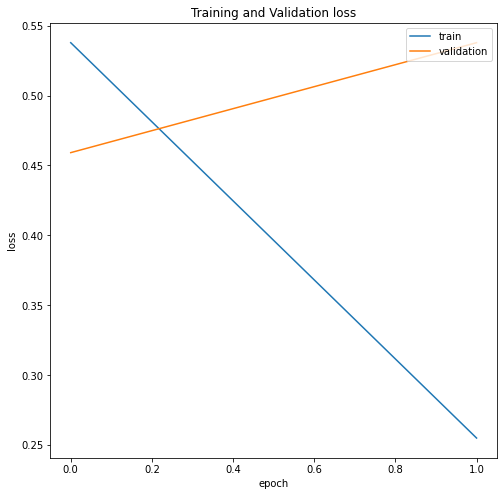

In [8]:


print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing Model


In [9]:

# we're still going to use a Tokenizer here, but we don't need to fit it
tokenizer = Tokenizer(num_words=10000)
# for human-friendly printing
labels = ['fake', 'real']

# read in our saved dictionary
with open('dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])

    return wordIndices

# read in your saved model structure
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('model.h5')

predictions = []

f = open("output.txt","w")
for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in

    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
        # predict which bucket your input belongs in
    pred = model.predict(input)

    predictions.append(np.argmax(pred))


In [10]:

predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1_score = 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1_score], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,345,81
Positive,95,241


In [11]:
results

,Value
Accuracy,0.769029
Precision,0.748447
FPR,0.190141
Recall,0.717262
F1,0.732523


### Summary of Base model
- The highest achievable accuracy is 77%
- The best FPR is 0.09
- Model starts overfitting from the first epoch
- Validation loss never goes below ~0.45
- Attempts were made to vary the batch size. Large batch sizes yield worse performance. The best performance is at 32 or 16
- Increasing the number of layers also results in worse performance. Less layers produce better performance
- Drop out layers make little to no difference in performance
- Including tweets without the keyword seems to yield better performance
- Data cleaning produced a slightly less validation loss but not significant enough

# Self-trained Word2vec using Gensim

## using MLP

In [12]:
from gensim.models import Word2Vec, KeyedVectors

In [13]:
data2 = data_without_tockenization.copy()

In [14]:
#tokenize data
def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []
# store tweets in array for word2vec
for arr in tweet_data:
    tweet_data_array.append(arr)

In [15]:
# training own word2vec model
vector_size = 512
window_size = 10
# Create Word2Vec
word2vec = Word2Vec(sentences=tweet_data_array,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=3)

In [16]:
# save model
word2vec.save('ownWord2vec.model')

In [17]:
# load model
word2vec = Word2Vec.load('word2vec.model')

In [18]:
# word vector
X_vecs = word2vec.wv

X_vecs

In [19]:
# vector size
test_size = int(0.1*len(tweet_data))
train_size = len(tweet_data) - test_size

avg_length = 0.0
max_length = 0

for tweet in tweet_data:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tweet_data))))
print('Max tweet length: {}'.format(max_length))

max_tweet_length = 15

Average tweet length: 9.545514251937476
Max tweet length: 23


In [20]:
import keras.backend as K
### train - test split
training, testing = train_test_split(tockenized_data, test_size=0.1, random_state=42, shuffle=True)

x_train = training['text']
y_train = training['target']

x_test = testing['text']
y_test = testing['target']

# variables for storing word2vec representations of tweets
X_train = np.zeros((len(training), max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((len(training), 2), dtype=np.int32)
X_test = np.zeros((len(testing), max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((len(testing), 2), dtype=np.int32)

# converting tweets(training set) to word2vec representations
train_y = keras.utils.to_categorical(y_train, 2)
t=0
for index, tweet in enumerate(x_train):
    for word in tweet:
        if word not in X_vecs:
            continue
        else:
            X_train[index, t, :] = X_vecs[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
                


In [21]:
X_train.shape

(6851, 15, 512)

In [22]:
y_train.shape

(6851,)

In [23]:
# converting tweets(testing set) to word2vec representations
test_y = np.array(test_y)

t=0
for index, tweet in enumerate(x_test):
    for word in tweet:
        if word not in X_vecs:
            continue
        else:
            X_test[index, t, :] = X_vecs[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
#             print(test_y['target'] ,'\n')
            if test_y[index] == 1:
                 Y_test[index, :] = [1.0, 0.0] 
            else:
                Y_test[index, :] = [0.0, 1.0] 
#             Y_test[index, :] = [1.0, 0.0] if test_y[1] == 0 else [0.0, 1.0]

In [1]:
# Creating a model
embedding_features = 16
model = Sequential()
model.add(word2vec.wv.get_keras_embedding(train_embeddings=False))
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

print(model.summary())

history = model.fit(train_x, train_y,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('LSTM1_EmbeddingModel.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('LSTM1_EmbeddingModel.h5')

print('saved model!')

NameError: name 'Sequential' is not defined

## Using LSTM

### Training own Word2vec model

In [126]:
data2 = data_without_tockenization.copy()

In [127]:

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []

for arr in tweet_data:
    tweet_data_array.append(arr)

In [128]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [192]:
vector_size = 512
window_size = 10
# Create Word2Vec
word2vec_self_trained = Word2Vec(sentences=tweet_data_array,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=3)

In [193]:
word2vec_self_trained.save('word2vecSelfTrained.model')

In [194]:
word2vec_self_trained = Word2Vec.load('word2vecSelfTrained.model')

In [195]:
X_vecs_self_trained = word2vec_self_trained.wv

X_vecs_self_trained

In [196]:
test_size = int(0.1*len(tweet_data))
train_size = len(tweet_data) - test_size

avg_length = 0.0
max_length = 0

for tweet in tweet_data:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tweet_data))))
print('Max tweet length: {}'.format(max_length))

max_tweet_length = 15

Average tweet length: 9.545514251937476
Max tweet length: 23


In [197]:
import keras.backend as K
### train - test split
training, testing = train_test_split(tockenized_data, test_size=0.1, random_state=42, shuffle=True)

training

x_train = training['text']
y_train = training['target']

x_test = testing['text']
y_test = testing['target']


X_train = np.zeros((len(training), max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((len(training), 2), dtype=np.int32)
X_test = np.zeros((len(testing), max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((len(testing), 2), dtype=np.int32)

train_y = np.array(y_train)

t=0
for index, tweet in enumerate(x_train):
    for word in tweet:
        if word not in X_vecs_self_trained:
            continue
        else:
            X_train[index, t, :] = X_vecs_self_trained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
                
            if train_y[index] == 1:
                 Y_train[index, :] = [1.0, 0.0] 
            else:
                Y_train[index, :] = [0.0, 1.0] 


In [198]:
test_y = np.array(y_test)

In [199]:
t=0
for index, tweet in enumerate(x_test):
    for word in tweet:
        if word not in X_vecs_self_trained:
            continue
        else:
            X_test[index, t, :] = X_vecs_self_trained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
#             print(test_y['target'] ,'\n')
            if test_y[index] == 1:
                 Y_test[index, :] = [1.0, 0.0] 
            else:
                Y_test[index, :] = [0.0, 1.0] 
#             Y_test[index, :] = [1.0, 0.0] if test_y[1] == 0 else [0.0, 1.0]

In [200]:
train_y = keras.utils.to_categorical(y_train, 2)
train_y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [201]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()

model.add(LSTM(512))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

In [139]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [140]:
model.fit(X_train, Y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

Epoch 1/10
386/386 [==============================] - 80s 207ms/step - loss: 0.5158 - accuracy: 0.7607 - precision: 0.7607 - recall: 0.7620 - val_loss: 0.5223 - val_accuracy: 0.7595 - val_precision: 0.7595 - val_recall: 0.7595
Epoch 2/10
386/386 [==============================] - 78s 203ms/step - loss: 0.4568 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7979 - val_loss: 0.4852 - val_accuracy: 0.7843 - val_precision: 0.7843 - val_recall: 0.7843
Epoch 3/10
386/386 [==============================] - 76s 196ms/step - loss: 0.4277 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8088 - val_loss: 0.4708 - val_accuracy: 0.7930 - val_precision: 0.7930 - val_recall: 0.7930
Epoch 4/10
386/386 [==============================] - 75s 195ms/step - loss: 0.3865 - accuracy: 0.8294 - precision: 0.8294 - recall: 0.8307 - val_loss: 0.5147 - val_accuracy: 0.7799 - val_precision: 0.7799 - val_recall: 0.7799
Epoch 00004: early stopping


In [141]:
X_train.shape

(6851, 15, 512)

In [142]:
model.evaluate(X_test,Y_test,batch_size=16)

48/48 [==============================] - 3s 61ms/step - loss: 0.5345 - accuracy: 0.7782 - precision: 0.7782 - recall: 0.7803


[0.5345075726509094, 0.778215229511261, 0.778215229511261, 0.7802631855010986]

In [167]:
y_test_lstm_word2vec_self_trained = []

for ind, lab in Y_test:
    if Y_test[ind][0] == 0:
        y_test_lstm_word2vec_self_trained.append(0)
    else:
        y_test_lstm_word2vec_self_trained.append(1)

In [168]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)


tn_lstm_word2vec_self_trained, fp_lstm_word2vec_self_trained, fn_lstm_word2vec_self_trained, tp_lstm_word2vec_self_trained = confusion_matrix(y_test_lstm_word2vec_self_trained, y_pred).ravel()
precision_lstm_word2vec_self_trained = tp_lstm_word2vec_self_trained / (tp_lstm_word2vec_self_trained + fp_lstm_word2vec_self_trained)
accuracy_lstm_word2vec_self_trained = (tp_lstm_word2vec_self_trained + tn_lstm_word2vec_self_trained) / (tn_lstm_word2vec_self_trained + fp_lstm_word2vec_self_trained +fn_lstm_word2vec_self_trained +tp_lstm_word2vec_self_trained)
falsePositiveRate_lstm_word2vec_self_trained = fp_lstm_word2vec_self_trained / (fp_lstm_word2vec_self_trained + tn_lstm_word2vec_self_trained)
recall_lstm_word2vec_self_trained = tp_lstm_word2vec_self_trained/(tp_lstm_word2vec_self_trained+fn_lstm_word2vec_self_trained)
f1_score_lstm_word2vec_self_trained = 2 * ((recall_lstm_word2vec_self_trained*precision_lstm_word2vec_self_trained)/(recall_lstm_word2vec_self_trained+precision_lstm_word2vec_self_trained))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy_lstm_word2vec_self_trained, precision_lstm_word2vec_self_trained, falsePositiveRate_lstm_word2vec_self_trained, recall_lstm_word2vec_self_trained,f1_score_lstm_word2vec_self_trained], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results_lstm_word2vec_self_trained = pd.DataFrame(d) 
  

data = {'Negative':[tn_lstm_word2vec_self_trained, fn_lstm_word2vec_self_trained], 'Positive':[fp_lstm_word2vec_self_trained, tp_lstm_word2vec_self_trained]} 
  
# Creates pandas DataFrame. 
df_lstm_word2vec_self_trained = pd.DataFrame(data, index =['Negative', 'Positive']) 
df_lstm_word2vec_self_trained

,Negative,Positive
Negative,229,107
Positive,63,363


In [169]:
results_lstm_word2vec_self_trained

,Value
Accuracy,0.776903
Precision,0.772340
FPR,0.318452
Recall,0.852113
F1,0.810268


## Using pre-trained word2vec model

In [176]:
import gensim.downloader as api

In [177]:
corpus = api.load('text8')

In [178]:
from gensim.models.word2vec import Word2Vec
pretrainedModel = Word2Vec(corpus)

In [185]:
word2vec.save('pretrainedModel.model')
word2vec_pretrained = Word2Vec.load('pretrainedModel.model')

In [186]:
X_vecs_pretrained = word2vec_pretrained.wv

X_vecs_pretrained

In [187]:
test_size = int(0.1*len(tweet_data))
train_size = len(tweet_data) - test_size

avg_length = 0.0
max_length = 0

for tweet in tweet_data:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tweet_data))))
print('Max tweet length: {}'.format(max_length))

max_tweet_length = 15

Average tweet length: 9.545514251937476
Max tweet length: 23


In [188]:
import keras.backend as K
### train - test split
training, testing = train_test_split(tockenized_data, test_size=0.1, random_state=42, shuffle=True)

training

x_train = training['text']
y_train = training['target']

x_test = testing['text']
y_test = testing['target']


X_train = np.zeros((len(training), max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((len(training), 2), dtype=np.int32)
X_test = np.zeros((len(testing), max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((len(testing), 2), dtype=np.int32)

train_y = np.array(y_train)

t=0
for index, tweet in enumerate(x_train):
    for word in tweet:
        if word not in X_vecs_pretrained:
            continue
        else:
            X_train[index, t, :] = X_vecs_pretrained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
                
            if train_y[index] == 1:
                 Y_train[index, :] = [1.0, 0.0] 
            else:
                Y_train[index, :] = [0.0, 1.0] 


In [189]:
test_y = np.array(y_test)
t=0
for index, tweet in enumerate(x_test):
    for word in tweet:
        if word not in X_vecs_pretrained:
            continue
        else:
            X_test[index, t, :] = X_vecs_pretrained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
#             print(test_y['target'] ,'\n')
            if test_y[index] == 1:
                 Y_test[index, :] = [1.0, 0.0] 
            else:
                Y_test[index, :] = [0.0, 1.0] 
#             Y_test[index, :] = [1.0, 0.0] if test_y[1] == 0 else [0.0, 1.0]

In [190]:
train_y = keras.utils.to_categorical(y_train, 2)
train_y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [191]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()

model.add(LSTM(512))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

In [156]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [157]:
model.fit(X_train, Y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

Epoch 1/10
386/386 [==============================] - 71s 183ms/step - loss: 0.5173 - accuracy: 0.7606 - precision: 0.7606 - recall: 0.7618 - val_loss: 0.5092 - val_accuracy: 0.7726 - val_precision: 0.7726 - val_recall: 0.7726
Epoch 2/10
386/386 [==============================] - 60s 154ms/step - loss: 0.4646 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7930 - val_loss: 0.4824 - val_accuracy: 0.7682 - val_precision: 0.7682 - val_recall: 0.7682
Epoch 3/10
386/386 [==============================] - 58s 151ms/step - loss: 0.4226 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8125 - val_loss: 0.4704 - val_accuracy: 0.8047 - val_precision: 0.8047 - val_recall: 0.8047
Epoch 4/10
386/386 [==============================] - 59s 152ms/step - loss: 0.3903 - accuracy: 0.8284 - precision: 0.8284 - recall: 0.8297 - val_loss: 0.4882 - val_accuracy: 0.7843 - val_precision: 0.7843 - val_recall: 0.7843
Epoch 00004: early stopping


In [158]:
model.evaluate(X_test,Y_test,batch_size=16)

48/48 [==============================] - 3s 56ms/step - loss: 0.5243 - accuracy: 0.7743 - precision: 0.7743 - recall: 0.7763


[0.5243053436279297,
 0.7742782235145569,
 0.7742782235145569,
 0.7763158082962036]

In [171]:
y_test_lstm_word2vec_pretrained = []

for ind, lab in Y_test:
    if Y_test[ind][0] == 0:
        y_test_lstm_word2vec_pretrained.append(0)
    else:
        y_test_lstm_word2vec_pretrained.append(1)

In [173]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)


tn_lstm_word2vec_pretrained, fp_lstm_word2vec_pretrained, fn_lstm_word2vec_pretrained, tp_lstm_word2vec_pretrained = confusion_matrix(y_test_lstm_word2vec_pretrained, y_pred).ravel()
precision_lstm_word2vec_pretrained = tp_lstm_word2vec_pretrained / (tp_lstm_word2vec_pretrained + fp_lstm_word2vec_pretrained)
accuracy_lstm_word2vec_pretrained = (tp_lstm_word2vec_pretrained + tn_lstm_word2vec_pretrained) / (tn_lstm_word2vec_pretrained + fp_lstm_word2vec_pretrained +fn_lstm_word2vec_pretrained +tp_lstm_word2vec_pretrained)
falsePositiveRate_lstm_word2vec_pretrained = fp_lstm_word2vec_pretrained / (fp_lstm_word2vec_pretrained + tn_lstm_word2vec_pretrained)
recall_lstm_word2vec_pretrained = tp_lstm_word2vec_pretrained/(tp_lstm_word2vec_pretrained+fn_lstm_word2vec_pretrained)
f1_score_lstm_word2vec_pretrained = 2 * ((recall_lstm_word2vec_pretrained*precision_lstm_word2vec_pretrained)/(recall_lstm_word2vec_pretrained+precision_lstm_word2vec_pretrained))

# Intialise data to Dicts of series. 
d_lstm_word2vec_pretrained = {'Value' : pd.Series([accuracy_lstm_word2vec_pretrained, precision_lstm_word2vec_pretrained, falsePositiveRate_lstm_word2vec_pretrained, recall_lstm_word2vec_pretrained,f1_score_lstm_word2vec_pretrained], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results_lstm_word2vec_pretrained = pd.DataFrame(d_lstm_word2vec_pretrained) 
  

data_lstm_word2vec_pretrained = {'Negative':[tn_lstm_word2vec_pretrained, fn_lstm_word2vec_pretrained], 'Positive':[fp_lstm_word2vec_pretrained, tp_lstm_word2vec_pretrained]} 
  
# Creates pandas DataFrame. 
df_lstm_word2vec_pretrained = pd.DataFrame(data_lstm_word2vec_pretrained, index =['Negative', 'Positive']) 
df_lstm_word2vec_pretrained

,Negative,Positive
Negative,229,107
Positive,63,363


In [174]:
results_lstm_word2vec_pretrained

,Value
Accuracy,0.776903
Precision,0.772340
FPR,0.318452
Recall,0.852113
F1,0.810268
